# Real Time Emotion Detection

### Import Dependencies

In [11]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from pathlib import Path
import time
import matplotlib.pyplot as plt
import pandas as pd


### Configuration

In [2]:
MODEL_PATH = "../../models/FC211042_Heshani/best_model.keras"     
IMG_SIZE = 160                      
CLASSES = ["angry", "happy", "sad", "surprise", "neutral"]  

SAVE_DIR = Path("captured_faces")
SAVE_DIR.mkdir(exist_ok=True)

print("Configuration loaded")

Configuration loaded


### Load Model

In [3]:
print("Loading model...")
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully!")

Loading model...
Model loaded successfully!


c:\Users\heshm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 192 variables whereas the saved optimizer has 196 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Load Face Detector

In [4]:
print("Loading model...")
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
if face_cascade.empty():
    raise IOError("Haarcascade not found.")
else:
    print("Haarcascade face detector loaded.")

Loading model...
✅ Model loaded successfully!
Haarcascade face detector loaded.


### Open Webcam

In [6]:
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)  

if not cap.isOpened():
    raise IOError("Cannot open webcam.")

print("\nReal-Time Emotion Detection started.")
print("➡ Press 's' to save detected face for evaluation.")
print("➡ Press 'q' to quit.\n")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        face_resized = cv2.resize(face_img, (IMG_SIZE, IMG_SIZE))
        face_array = np.expand_dims(face_resized / 255.0, axis=0)

        preds = model.predict(face_array, verbose=0)[0]
        label = CLASSES[np.argmax(preds)]
        conf = np.max(preds) * 100

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, f"{label} ({conf:.1f}%)", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('s'):
            fname = SAVE_DIR / f"face_{int(time.time())}_{label}.jpg"
            cv2.imwrite(str(fname), face_img)
            print(f"💾 Saved: {fname.name}")
        elif key == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            print("\n👋 Detection ended.\n")
            break

    cv2.imshow("Real-Time Emotion Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



Real-Time Emotion Detection started.
➡ Press 's' to save detected face for evaluation.
➡ Press 'q' to quit.



### Evaluate saved Faces

Found 3 saved samples for evaluation.



C:\Users\heshm\AppData\Local\Temp\ipykernel_18188\535114469.py:25: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\heshm\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


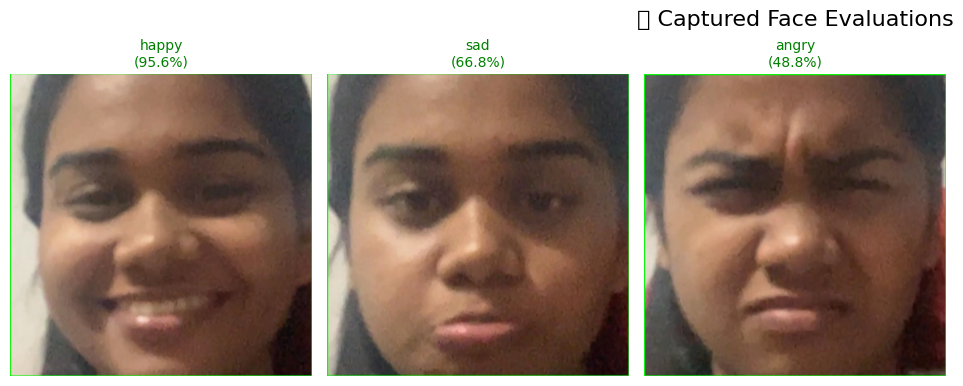

In [9]:
saved_faces = sorted(SAVE_DIR.glob("*.jpg"))
print(f"Found {len(saved_faces)} saved samples for evaluation.\n")

if not saved_faces:
    print("No captured faces found. Please run detection and press 's' to save.")
else:
    results = []
    plt.figure(figsize=(16, 8))
    for i, img_path in enumerate(saved_faces):
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        arr = np.expand_dims(image.img_to_array(img) / 255.0, axis=0)

        preds = model.predict(arr, verbose=0)[0]
        label = CLASSES[np.argmax(preds)]
        conf = np.max(preds) * 100
        results.append({"file": img_path.name, "prediction": label, "confidence": conf})

        plt.subplot(2, 5, i + 1)
        plt.imshow(cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB))
        plt.title(f"{label}\n({conf:.1f}%)", color="green", fontsize=10)
        plt.axis("off")
        if i == 9: break  # show up to 10 samples

    plt.suptitle("📷 Captured Face Evaluations", fontsize=16)
    plt.tight_layout()
    plt.show()


### Save Evaluation Summary

In [12]:
if saved_faces:
    df = pd.DataFrame(results)
    df.to_csv("real_time_face_eval.csv", index=False)
    print("Evaluation summary saved → real_time_face_eval.csv\n")
    display(df.head())

Evaluation summary saved → real_time_face_eval.csv



,file,prediction,confidence
0,face_1762454862_happy.jpg,happy,95.554741
1,face_1762454882_sad.jpg,sad,66.803383
2,face_1762454926_angry.jpg,angry,48.836689


### Summary stat

In [13]:
if saved_faces:
    avg_conf = np.mean([r["confidence"] for r in results])
    print(f"Average Model Confidence: {avg_conf:.2f}%")
    counts = pd.Series([r["prediction"] for r in results]).value_counts()
    print("\nEmotion Prediction Distribution:")
    print(counts)



Average Model Confidence: 70.40%

Emotion Prediction Distribution:
happy    1
sad      1
angry    1
Name: count, dtype: int64
